출처 : https://github.com/bwcho75/dataanalyticsandML/tree/master/Clustering

IRIS 데이터에 대해 클러스터링을 해보고 모델 평가를 하는 코드입니다.    
이 코드에서는 교차표를 이용해 결과를 확인하는데, 이 외에도 파라머_Clustering.ipynb에 나오는 silhouette_score나 수업시간에 배운 다른 모델 평가 방식을 사용해보길 바랍니다.    
과제 #3은 Mall_Customer.csv 데이터를 불러오고, 전처리와 EDA를 한 후,    
수업시간에 배운 아래의 세 가지 방법 + 새로운 방법 최소 한 가지를 이용해 Clustering을 하고      
하이퍼파라미터도 변화시켜보고    
다양한 Clustering 방법에 대해 비교/평가하는 과제입니다.

## Read IRIS Sample data

In [2]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Hierarchical Clustering

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


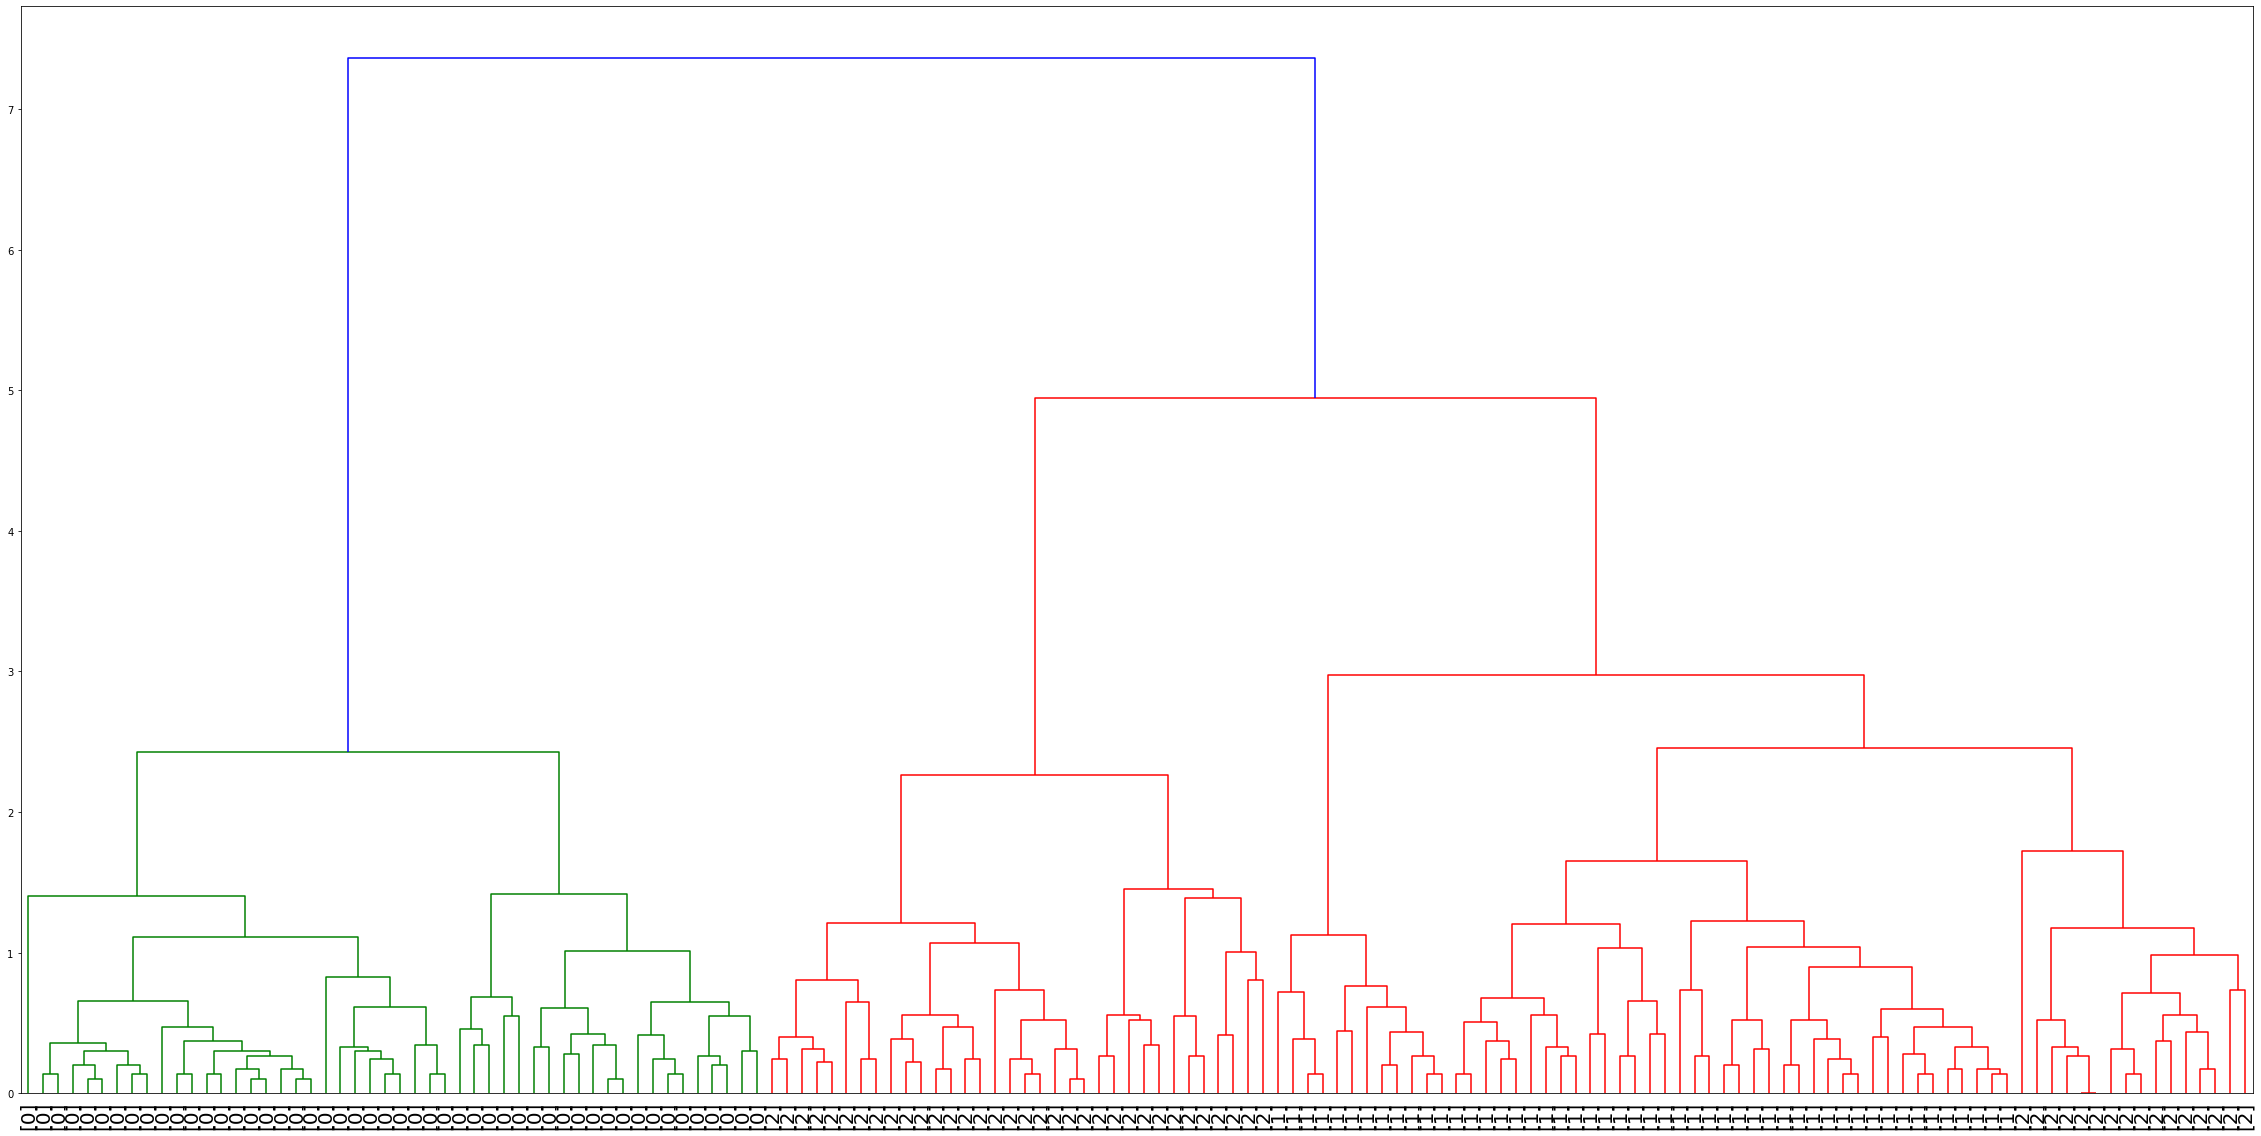

In [4]:
# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate the linkage: mergings
# method = 'single','complete', 'average', 'weighted', 'centroid', 'median', 'ward'
mergings = linkage(data, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(40,20))
dendrogram(mergings,
           labels = labels.as_matrix(columns=['labels']),
           leaf_rotation=90,
           leaf_font_size=20,
)
plt.show()

## Evaluate model with Cross tabulation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

In [7]:
from scipy.cluster.hierarchy import fcluster

# fcluster(linkage함수, 클러스터링을 멈추도록하는 임계값, 거리를 기준으로)
# 위의 덴드로그램에서 클러스터간의 거리가 3인 지점에서 자르면 3개의 cluster가 형성됨을 알 수 있다.
# 따라서 임계값을 3으로 정한다.
predict = pd.DataFrame(fcluster(mergings,3,criterion='distance'))
predict.columns=['predict'] # predict column에 예측 결과

# 예측값과 라벨값 비교하기
ct = pd.crosstab(predict['predict'],labels['labels'])
print(ct)

labels    0   1   2
predict            
1        50   0   0
2         0   0  34
3         0  50  16


# K-means Clustering

In [5]:
feature = data[ ['Sepal length','Sepal width','Petal length','Petal width']]

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(feature)

predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

In [8]:
r.head()

,Sepal length,Sepal width,Petal length,Petal width,predict
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


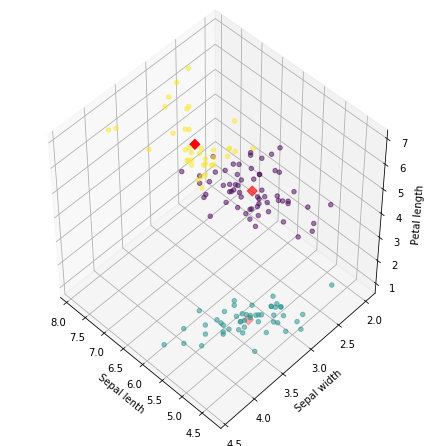

In [9]:
centers = pd.DataFrame(model.cluster_centers_,columns=['Sepal length','Sepal width','Petal length','Petal width'])
center_x = centers['Sepal length']
center_y = centers['Sepal width']
center_z = centers['Petal length']

from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Sepal length'],r['Sepal width'],r['Petal length'],c=r['predict'],alpha=0.5)
ax.scatter(center_x,center_y,center_z,s=50,marker='D',c='r')
ax.set_xlabel('Sepal lenth')
ax.set_ylabel('Sepal width')
ax.set_zlabel('Petal length')
plt.show()

## Evaluate model with Cross tabulation

In [10]:
ct = pd.crosstab(data['labels'],r['predict'])
print (ct)
print (model.inertia_)

predict   0   1   2
labels             
0         0  50   0
1        48   0   2
2        14   0  36
78.85144142614601


## Scaling value

In [31]:
# Scaling 한 후 적용해보기
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler,model)
pipeline.fit(feature)
predict = pd.DataFrame(pipeline.predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

ct = pd.crosstab(data['labels'],r['predict'])
print (ct)
print (model.inertia_)

predict   0   1   2
labels             
0        50   0   0
1         0  39  11
2         0  14  36
139.82049635974974


## 최적의 군집 수 K 결정 (Elbow Point)

Text(0.5, 1.0, 'Elbow curve')

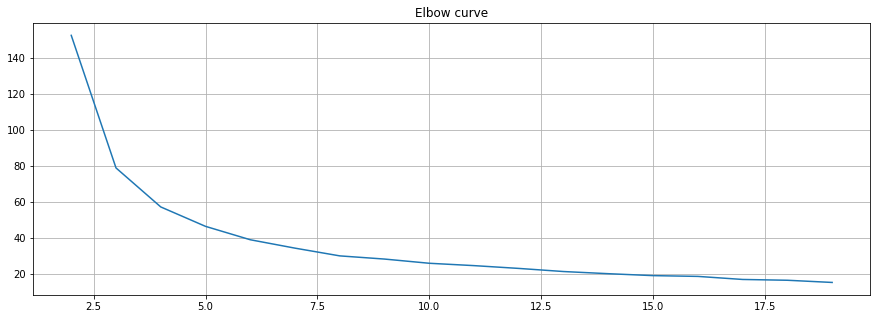

In [32]:
X = feature
distorsions = []

# 군집 수 K의 변화에 따라
# Inertia Value: 군집화가 된 후에, 각 중심점에서 군집내의 데이터간의 거리를 합산한 것
# 즉, 군집의 응집도를 나타내는 값
# 이 값을 구해 그래프로 그린다!
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

# 급격하게 하강하다가 변화의 폭이 크지 않는 지점 Elbow Point를 찾는다.

# DBSCAN

In [33]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = DBSCAN(eps=0.3,min_samples=6)
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

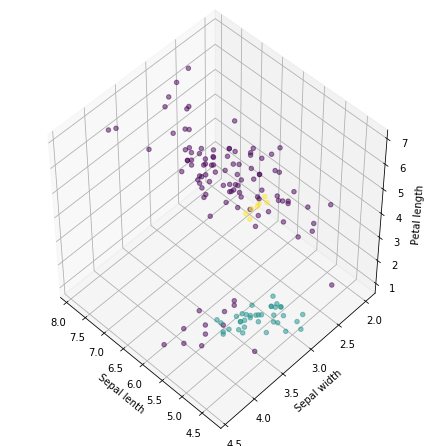

In [34]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Sepal length'],r['Sepal width'],r['Petal length'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Sepal lenth')
ax.set_ylabel('Sepal width')
ax.set_zlabel('Petal length')
plt.show()

## Evaluate model with Cross tabulation

In [36]:
ct = pd.crosstab(data['labels'],r['predict'])
print (ct)

predict  -1   0   1
labels             
0        13  37   0
1        43   0   7
2        50   0   0


## Scaling value

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = model = DBSCAN(min_samples=6)
pipeline = make_pipeline(scaler,model)
predict = pd.DataFrame(pipeline.fit_predict(feature))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature,predict],axis=1)

ct = pd.crosstab(data['labels'],r['predict'])
print (ct)

predict  -1   0   1   2   3
labels                     
0         7  43   0   0   0
1        13   0  31   6   0
2        22   0  10   0  18
